## Data set 
1. 2000-01-01~2011-12-01 (60% training dataset)
2. 2012-01-01~2015-12-1 (20% validation dataset0)
3. 2012-01-01~2020-12-1 (40% validation dataset1)
4. 2016-01-01~2020-12-1 (20% test dataset)
5. 2000-01-01~2020-12-1 (100% dataset)

In [2]:
!pip install utils
!pip install pymysql

     |████████████████████████████████| 51kB 2.7MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<function matplotlib.pyplot.show>

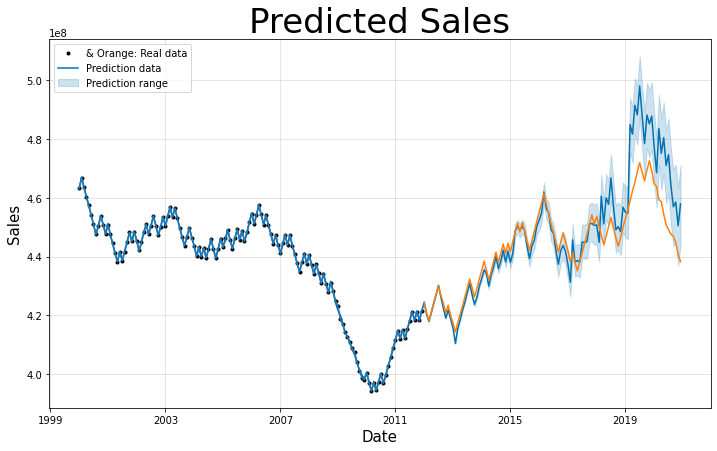

In [71]:
#######################Prophet model
import pymysql
from datetime import datetime, timedelta
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from math import sqrt
import numpy as np
from utils import *
#connect to database
dbCon = pymysql.connect(host='223.194.46.212', user='root', password='12345!', database='knowhow',
                       charset ='utf8', autocommit=True,
                       cursorclass=pymysql.cursors.DictCursor)

#Sales, variable cost, fixed cost (매출액, 변동비, 고정비)
y1='''SELECT cc_costbill.proamt_unit*cc_costbill.proq AS y, cc_costbill.periodym_cd*100 +1  AS ds
,cc_costbill.ic_dlvc+ cc_costbill.ic_ohdvc +cc_costbill.ic_idlc+cc_costbill.ic_idohc AS varialblecost,
cc_costbill.ic_dlfc + cc_costbill.ic_dlfc +cc_costbill.ic_dlfc AS fixedcost
FROM cc_costbill;'''

curs = dbCon.cursor()
curs.execute(y1)
result =curs.fetchall()

#make DB table into pandas dataframe
df = pd.DataFrame(result)

#int -> datetime
df['ds'] = df['ds'].astype(str)
df['ds'] = pd.to_datetime(df['ds'])
df=df[['ds','y','varialblecost','fixedcost']]
df = df.groupby(['ds'], as_index=False)['y','varialblecost','fixedcost'].agg('sum')

#Set dataset
x_train= df.loc[df['ds']<"2012-01-01"]#60%
x_val=df.loc[(df['ds']>="2012-01-01") & (df['ds']<"2016-01-01")]#20%
x_val1= df.loc[df['ds']>="2012-01-01"]#40%
x_test=df.loc[df['ds']>="2016-01-01"]#20%

#covid19 트렌드 설정 (special events)
covid = pd.DataFrame({
'holiday': 'covid19',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'inflation',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))

#Build model / 모델 만들기#################################
model= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.2,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#add regressor
model.add_regressor('varialblecost',prior_scale=0.5, mode='multiplicative')#변동비
model.add_regressor('fixedcost',prior_scale=0.5, mode='multiplicative')#고정비

#train data 2000-01-01~2014-12-01 60%
model.fit(x_train)

#전체 데이터 예측 100%
forecast3=model.predict(df)
fig = model.plot(forecast3, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(x_train['ds'], x_train['y'])
plt.plot(x_val1['ds'], x_val1['y'])

plt.show

## Created model using add_regression variable cost and fixed cost to predict Sales 
Validation
- validation dataset  2013-01-01~2016-12-01 (20%)

MAE: 1729877.236
MSE: 4055022661653.445
RMSE: 2013708.683
RMSLE: 0.005


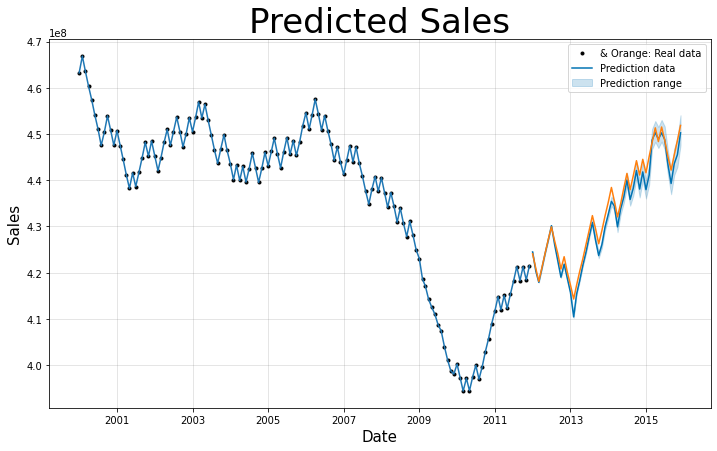

        Period  Expected sales  Real sales
144 2012-01-01       424492064   424111128
145 2012-02-01       420352694   420955634
146 2012-03-01       417925888   418121646
147 2012-04-01       421055363   421206236
148 2012-05-01       424177381   424198895
149 2012-06-01       427124237   427225385
150 2012-07-01       430172785   429922355
151 2012-08-01       426084280   426882952
152 2012-09-01       422518806   424109189
153 2012-10-01       419029741   420789865
154 2012-11-01       421862364   423465314
155 2012-12-01       418839057   420193614
156 2013-01-01       415723095   417353173
157 2013-02-01       410448850   414315120
158 2013-03-01       415342730   417274951
159 2013-04-01       418403719   420348620
160 2013-05-01       421663994   423027926
161 2013-06-01       424537741   426176772
162 2013-07-01       427777632   429165259
163 2013-08-01       430871869   432351246
164 2013-09-01       426964724   429476520
165 2013-10-01       423720140   426270242
166 2013-11

In [72]:
#validation 2012-01-01~2015-12-01
forecast_val=model.predict(x_val)

#(실제값, 예측값)
mae = mean_absolute_error(x_val['y'], forecast_val['yhat'])
MSE = mean_squared_error(x_val['y'], forecast_val['yhat'])
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(x_val['y'], forecast_val['yhat']))
r2 = r2_score(x_val['y'], forecast_val['yhat'])

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)
fig = model.plot(forecast_val, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(x_train['ds'], x_train['y'] )
plt.plot(x_val['ds'], x_val['y'] )

plt.show()
output= pd.DataFrame({'Period':  forecast_val.ds.values, 'Expected sales': forecast_val.yhat.values.astype(int), 'Real sales':x_val['y']})
print(output)

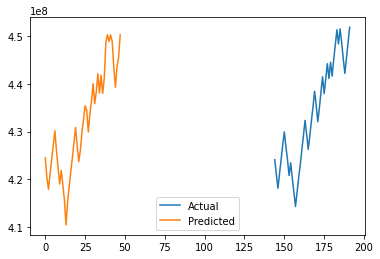

In [64]:
# x_val['y'], forecast_val['yhat']
plt.plot(x_val['y'], label='Actual')
plt.plot(forecast_val['yhat'], label='Predicted')

plt.legend()
plt.show()


 Test dataset
- 2016-01-01~2020-12-1 (20%)

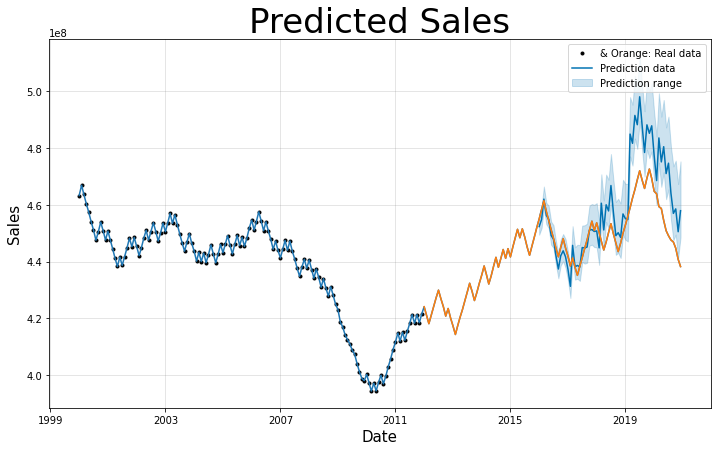

MAE: 9118966.219
MSE: 150482972625073.500
RMSE: 12267150.143
RMSLE: 0.026
        Period  Expected sales  Real sales
192 2016-01-01       452292998   454988253
193 2016-02-01       454799605   458269766
194 2016-03-01       461962592   461428720
195 2016-04-01       456222975   457637396
196 2016-05-01       454902828   454508503
197 2016-06-01       449188983   451155957
198 2016-07-01       447808694   448189446
199 2016-08-01       442081396   444730997
200 2016-09-01       437359287   441652509
201 2016-10-01       442020521   444934280
202 2016-11-01       443770912   448056612
203 2016-12-01       441672727   444796602
204 2017-01-01       437263933   441864571
205 2017-02-01       431267811   438377642
206 2017-03-01       445687000   441284557
207 2017-04-01       438143543   437933780
208 2017-05-01       438630426   435130114
209 2017-06-01       438116273   438385072
210 2017-07-01       444917429   441341304
211 2017-08-01       444762712   444602441
212 2017-09-01       44

In [70]:
# prediction 2016-01-01~2020-12-01
forecast_test = model.predict(x_test) 
# print(forecast_test[['ds','varialblecost', 'yhat', 'yhat_lower', 'yhat_upper']])
# prediction
fig = model.plot(forecast_test, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(df['ds'], df['y'] )
plt.plot(x_val1['ds'], x_val1['y'] )

plt.show()

#Validation
mae = mean_absolute_error(x_test['y'], forecast_test['yhat'])
MSE = mean_squared_error(x_test['y'], forecast_test['yhat'])
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(x_test['y'], forecast_test['yhat']))
r2 = r2_score(x_test['y'], forecast_test['yhat'])

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)
output= pd.DataFrame({'Period':  forecast_test.ds.values, 'Expected sales': forecast_test.yhat.values.astype(int), 'Real sales':x_test['y']})
print(output)

 validation1 dataset
- 2012-01-01~2020-12-1 (40%)

            ds          y  varialblecost  fixedcost
144 2012-01-01  424111128       29516316  123521994
145 2012-02-01  420955634       29400088  123149658
146 2012-03-01  418121646       29292227  122868549
147 2012-04-01  421206236       29406857  123233292
148 2012-05-01  424198895       29516099  123455304
..         ...        ...            ...        ...
247 2020-08-01  447585780       30490154  125620395
248 2020-09-01  446862539       30463855  125666607
249 2020-10-01  444705385       30348490  124946832
250 2020-11-01  440779142       30306145  124736904
251 2020-12-01  438231460       30300288  125027739

[108 rows x 4 columns]


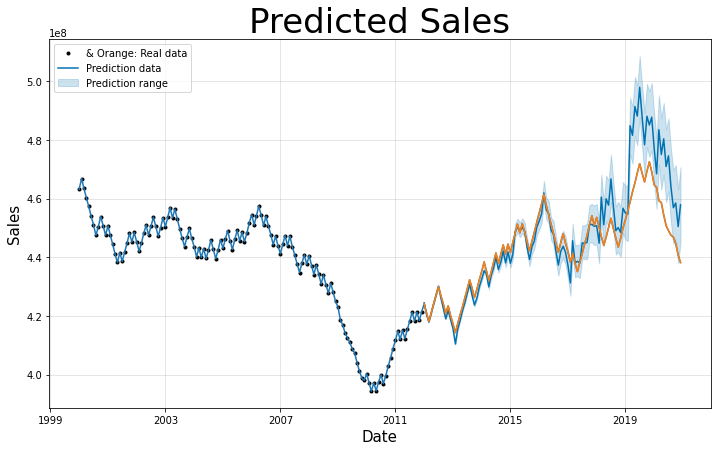

        Period  Expected sales  Real sales
144 2012-01-01       424492064   424111128
145 2012-02-01       420352694   420955634
146 2012-03-01       417925888   418121646
147 2012-04-01       421055363   421206236
148 2012-05-01       424177381   424198895
..         ...             ...         ...
247 2020-08-01       464062610   447585780
248 2020-09-01       456939449   446862539
249 2020-10-01       458522710   444705385
250 2020-11-01       450489058   440779142
251 2020-12-01       457889672   438231460

[108 rows x 3 columns]
MAE: 5834926.671
MSE: 85403883752442.375
RMSE: 9241422.172
RMSLE: 0.020


In [74]:
#x_val1 2012-01-01~2020-12-01
print(x_val1)
forecast_x_val1 = model.predict(x_val1) 
# print(forecast_test[['ds','varialblecost', 'yhat', 'yhat_lower', 'yhat_upper']])
# prediction
fig = model.plot(forecast_x_val1, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(df['ds'], df['y'] )
plt.plot(x_val1['ds'], x_val1['y'] )
plt.show()


output= pd.DataFrame({'Period':  forecast_x_val1.ds.values, 'Expected sales': forecast_x_val1.yhat.values.astype(int), 'Real sales':x_val1['y']})
print(output)
mae = mean_absolute_error(x_val1['y'], forecast_x_val1['yhat'])
MSE = mean_squared_error(x_val1['y'], forecast_x_val1['yhat'])
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(x_val1['y'], forecast_x_val1['yhat']))
r2 = r2_score(x_val1['y'], forecast_x_val1['yhat'])

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)

In [ ]:
# last_years = list()
# for i in range(1, 13):
#     last_years.append(['2013-%02d' % i])    
#     last_years.append(['2014-%02d' % i])    
#     last_years.append(['2015-%02d' % i])    
#     last_years.append(['2016-%02d' % i])
#     last_years.append(['2017-%02d' % i])
#     last_years.append(['2018-%02d' % i])
#     last_years.append(['2019-%02d' % i])
#     last_years.append(['2020-%02d' % i])        
# last_years = pd.DataFrame(last_years, columns = ['ds'])
# last_years['ds']= pd.to_datetime(last_years['ds'])
# print(last_years)

# # 예측하고 비교하기
# # 여기에서는 MAE를 살펴본다.
# forecast2 = model.predict(last_years)
# y_pred = forecast2['yhat'].values
# mae = mean_absolute_error(y_true, y_pred)
# MSE = mean_squared_error(y_true, y_pred)
# RMSE = np.sqrt(MSE)
# RMSLE = np.sqrt(mean_squared_log_error(y_true, y_pred))
# r2 = r2_score(y_true, y_pred)

# print('MAE: %.3f' % mae)
# print('MSE: %.3f' % MSE)
# print('RMSE: %.3f' % RMSE)
# print('RMSLE: %.3f' % RMSLE)
# print('Test r_squared: %.4f.' % (r2))


# Train 2000-01-01~2020-12-01 model_1
- Predict 3 months

In [79]:
#Build model_1 / 모델 만들기#################################
model_1= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.2,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#add regressor
model_1.add_regressor('varialblecost',prior_scale=0.5, mode='multiplicative')
model_1.add_regressor('fixedcost',prior_scale=0.5, mode='multiplicative')

model_1.fit(df)


            ds  varialblecost  fixedcost
0   2000-01-01       30552326  126957630
1   2000-02-01       30666440  127351863
2   2000-03-01       30549148  127111266
3   2000-04-01       30430586  126757206
4   2000-05-01       30316583  126471804
..         ...            ...        ...
250 2020-11-01       30306145  124736904
251 2020-12-01       30300288  125027739
252 2020-12-31       30552326  126957630
253 2021-01-31       30666440  127351863
254 2021-02-28       30549148  127111266

[255 rows x 3 columns]


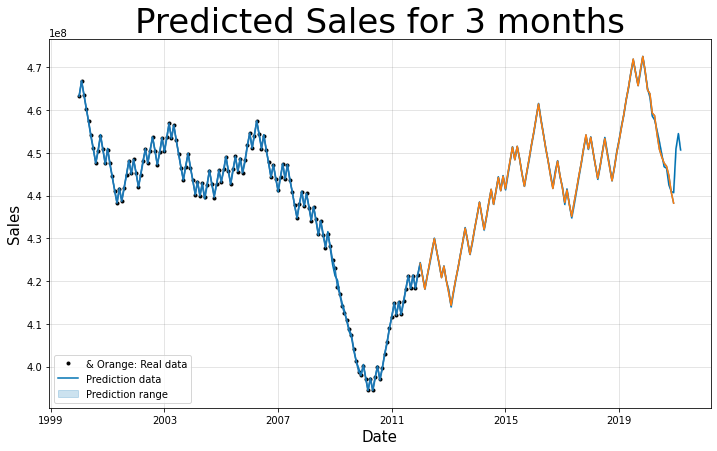

In [86]:
future = model_1.make_future_dataframe(periods=3, freq='M')
# print(future)

future['varialblecost']=pd.concat([df,df]).reset_index()['varialblecost']
future['fixedcost']=pd.concat([df,df]).reset_index()['fixedcost']

future.isna().sum()
print(future)
future=model_1.predict(future)
fig = model.plot(future, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales for 3 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(df['ds'], df['y'] )
plt.plot(x_val1['ds'], x_val1['y'] )
plt.show()


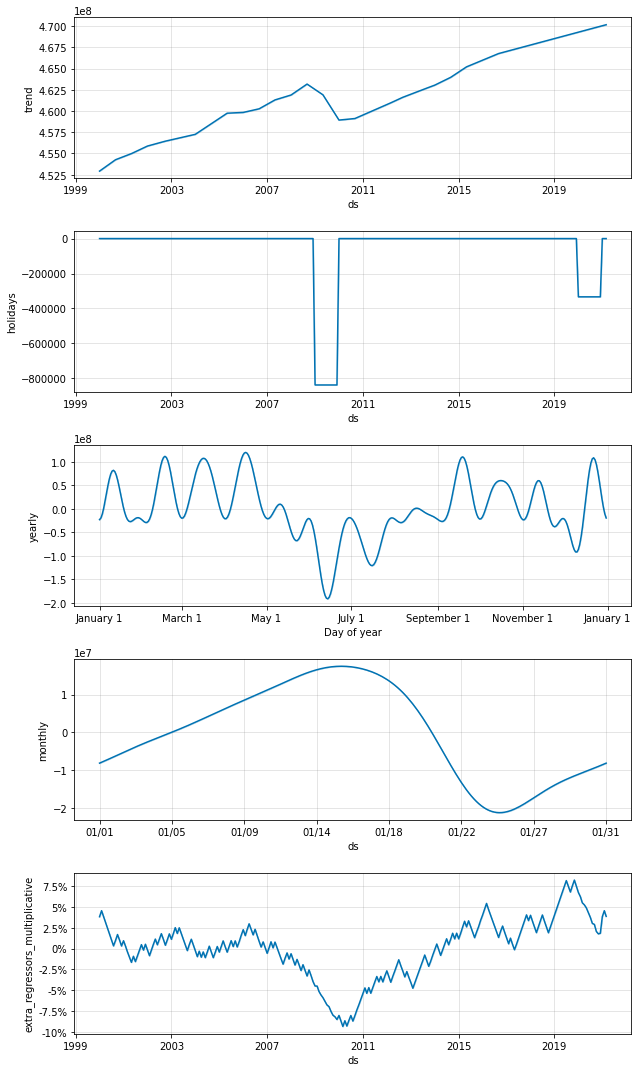

In [84]:
fig1 = model_1.plot_components(future)